# How PSPNet works?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#How-PSPNet-works?" data-toc-modified-id="How-PSPNet-works?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>How PSPNet works?</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Why-PSPNet-is-an-improvement-over-Fully-Convolutional-Network-(FCN)-based-segmentation?" data-toc-modified-id="Why-PSPNet-is-an-improvement-over-Fully-Convolutional-Network-(FCN)-based-segmentation?-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Why PSPNet is an improvement over Fully Convolutional Network (FCN) based segmentation?</a></span></li></ul></li><li><span><a href="#Encoder-Decoder-Architecture-for-Semantic-Segmentation" data-toc-modified-id="Encoder-Decoder-Architecture-for-Semantic-Segmentation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Encoder-Decoder Architecture for Semantic Segmentation</a></span><ul class="toc-item"><li><span><a href="#PSPNet-Encoder" data-toc-modified-id="PSPNet-Encoder-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>PSPNet Encoder</a></span><ul class="toc-item"><li><span><a href="#Dilated-Convolutions" data-toc-modified-id="Dilated-Convolutions-1.1.1.1"><span class="toc-item-num">1.1.1.1&nbsp;&nbsp;</span>Dilated Convolutions</a></span></li><li><span><a href="#Pyramid-Pooling-Module" data-toc-modified-id="Pyramid-Pooling-Module-1.1.1.2"><span class="toc-item-num">1.1.1.2&nbsp;&nbsp;</span>Pyramid Pooling Module</a></span></li><li><span><a href="#How-to-set-scales-in-arcgis.learn" data-toc-modified-id="How-to-set-scales-in-arcgis.learn-1.1.1.3"><span class="toc-item-num">1.1.1.3&nbsp;&nbsp;</span>How to set scales in <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#PSPNet-Decoder" data-toc-modified-id="PSPNet-Decoder-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>PSPNet Decoder</a></span><ul class="toc-item"><li><span><a href="#8x-upsampling-decoder" data-toc-modified-id="8x-upsampling-decoder-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>8x upsampling decoder</a></span></li><li><span><a href="#PSPNet-with-U-Net-like-decoder" data-toc-modified-id="PSPNet-with-U-Net-like-decoder-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>PSPNet with U-Net like decoder</a></span></li></ul></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Implementation in <code>arcgis.learn</code></a></span></li><li><span><a href="#PointRend-Enhancement" data-toc-modified-id="PointRend-Enhancement-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>PointRend Enhancement</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#References" data-toc-modified-id="References-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></li></ul></div>

### Introduction

In the guide [How u-net works](https://developers.arcgis.com/python/guide/how-unet-works/), we have learned in detail about semantic segmentation using U-net in the ArcGIS API for Python. There are many other semantic segmentation algorithms like PSPNet, Deeplab, etc. In this guide, we will mainly focus on [Pyramid scene parsing network (PSPNet)](https://arxiv.org/abs/1612.01105) [1] which is one of the most well-recognized image segmentation algorithms as it won ImageNet Scene Parsing Challenge 2016 and its paper is highly cited by the computer vision community. PSPNet is another semantic segmentation model along with the Unet that has been implemented into the `arcgis.learn` module which can be trained to classify pixels in a raster.

Note: To follow the guide below, we assume that you have some basic understanding of deep learning and the convolutional neural networks (CNNs). For a detailed review of CNNs, please review Stanford University's CS231n: Convolutional Neural Networks for Visual Recognition course ([Course Notes](http://cs231n.github.io/)). Also, we recommend to read [How u-net works](https://developers.arcgis.com/python/guide/how-unet-works/) before reading this one.

### Why PSPNet is an improvement over Fully Convolutional Network (FCN) based segmentation?

The PSPNet architechture takes into account the global context of the image to predict the local level predictions hence gives better performance on benchmark datasets like PASCAL VOC 2012 and cityscapes. The model was needed because FCN based pixel classifiers were not able to capture the context of the whole image.




Let's understand through an example below:

<figure>
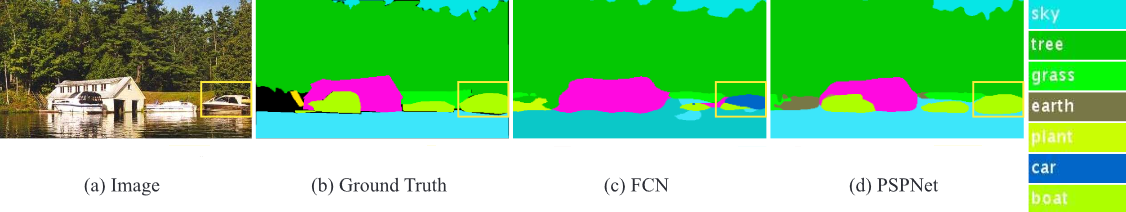

<center><figcaption>Figure 1. Image comparing FCN and PSPNet [1]</figcaption></center>
</figure>

The boat inside the yellow bounding box in (a) is classified as a "car" by a FCN based classifier (c). It is because of its shape and appearance. But it is uncommon to see a car in river. If the model could gain information from the context, for example in our case water around the object, it will be able to correctly classify it. The PSPNet model (d) is able to capture the context of the whole image to classify the object as a boat (Green).

## Encoder-Decoder Architecture for Semantic Segmentation

Most semantic segmentation models contains two parts, i.e an **Encoder** and a **Decoder**. The Encoder is responsible for the extracting out features from the image, the decoder is the one which predicts the class of the pixel at the end. A typical **Encoder-Decoder** for segmentation task looks like the architecture shown below.

<figure>
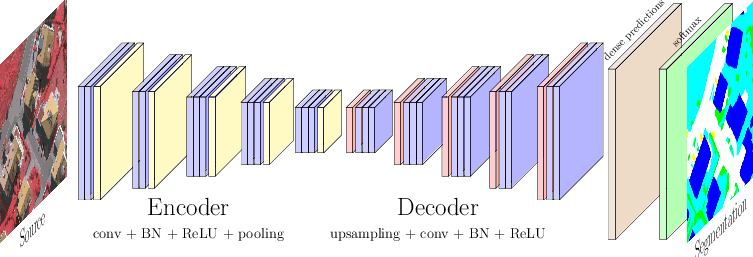
<center>
    <figcaption>Figure 2. Encoder-Decoder Networks for Semantic Segmentation [6]</figcaption>
</center>
</figure>

### PSPNet Encoder

The PSPNet encoder contains the CNN backbone with dilated convolutions along with the pyramid pooling module.

#### Dilated Convolutions

In the last layers of the backbone, we replace the traditional convolutional layers with [Dilated convolution](https://arxiv.org/abs/1705.09914) layers, which helps in increasing the receptive field. This Dilated convolution layers are placed in the last two blocks of the backbone. Hence the feature recieved at the end of the backbone contains richer features.
The illustration[2] shows what dilated convolutions do and how is it different from convolutions.

<figure>
        <img src="../../static/img/dilated.gif", align="left">
        <img src="../../static/img/normal_convolution.gif">
<center>
    <figcaption>Figure 3. Animation of convolution with <b>dilation=2 (left)</b> and <b>dilation=1(right)</b>. When dilation=1, it is just the standard convolution operation. [2]</figcaption>
</center>
</figure>

The value of dilation specifies the sparsity while doing the convolution. We can see that the receptive field for dilated convolution is larger as compared to the standard convolution. The size of the receptive field indicates how much context information we use. In PSPNet, the last two blocks of the backbone have dilation values 2 and 4 respectively.

#### Pyramid Pooling Module

The pyramid pooling module is the main part of this model as it helps the model to capture the global context in the image which helps it to classify the pixels based on the global information present in the image. 

<figure>
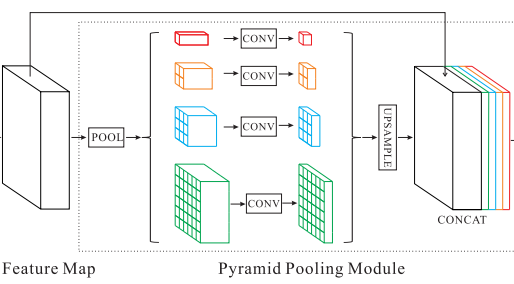
<center><figcaption>Figure 4. PSPNet Architecture [1]</figcaption></center>
</figure>

The feature map from the backbone is pooled at different sizes and then passed through a convolution layer and after which upsampling takes place on the pooled features to make them the same size as of the original feature map. Finally, the upsampled maps are concatenated with the original feature map to be passed to the decoder. This technique fuses the features different scales hence aggregating the overall context.

For example in the above figure from the paper, the four colours represent different scales which are 6, 3, 2, and 1 for colours green, blue, orange and red respectively. The feature map is pooled at these scales after which they are convolved with 1x1 filters to reduce the feature depth. Then all of these features are then upsampled at the size of the feature map and are concatenated. The 1x1 feature is the most coarse pooled feature map as it captures all the information in just 1x1 spatial location, whereas as the spatial resolution increases, the high resolution features are also taken in account as in the case of 6x6 pyramid size. A rule of thumb is that the if the pyramid size is small i.e ~1 or 2, the model will capture the low resolution and bigger features whereas if the  the pyramid size is bigger i.e ~6-8, the model will be able to capture high resolution features.

#### How to set scales in `arcgis.learn`

In `arcgis.learn` you can pass the parameter `pyramid_sizes` to the `PSPNetClassifier` model to set the values at which you want the model to pool the features from the feature map. The default value of this parameter is (1, 3, 5, 6) which is used in most implementations. We can set `pyramid_sizes` according to our dataset. So, if we have a large variance in the size of features to be segmented, we might want to increase the number of pyramids and the size of pyramids in the PSPNet module, on the other hand if we have similiar sized features, we can get away with only one or two level pyramid.

### PSPNet Decoder

After the encoder has extracted out features of the image, it is the turn of the decoder to take those features and convert them into predictions by passing them into its layers. The decoder is just another network which takes in features and results into predictions.

#### 8x upsampling decoder
The PSPNet model is  not a complete segmentation model in itself, it is just an encoder, which means it is just half of what is required for image segmentation. The most common decoders that are found in various implementations of PSPNet is a convolution layer followed by a 8x bilinear-upsampling.

<figure>
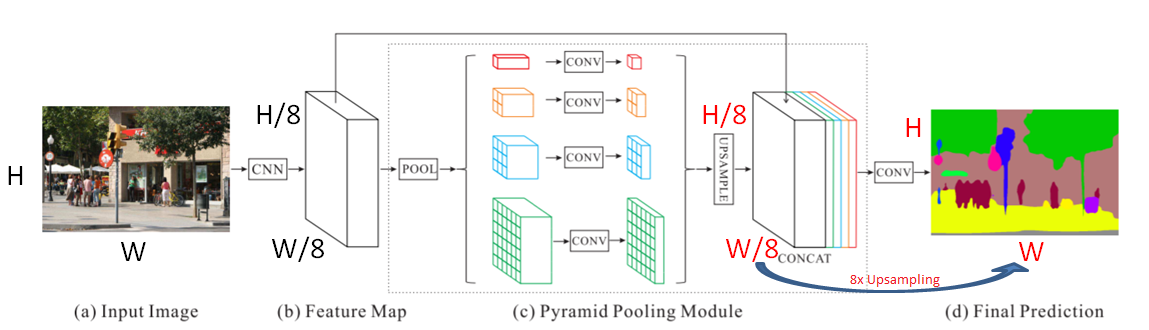
<center>
    <figcaption>Figure 5. PSPNet with 8x upsampling decoder [7]</figcaption>
</center>
</figure>

There is a downside of having a **8x upsmapling decoder** in the end is that there are no learnable parameters in them hence the results that we get are blobby and it fails to capture high resolution information from the image.

#### PSPNet with U-Net like decoder

Now, to get the high resolution output from the model, one way is to have a decoder which has learnable parameters and can take in intermidiate features from the encoder as the input.

<figure>
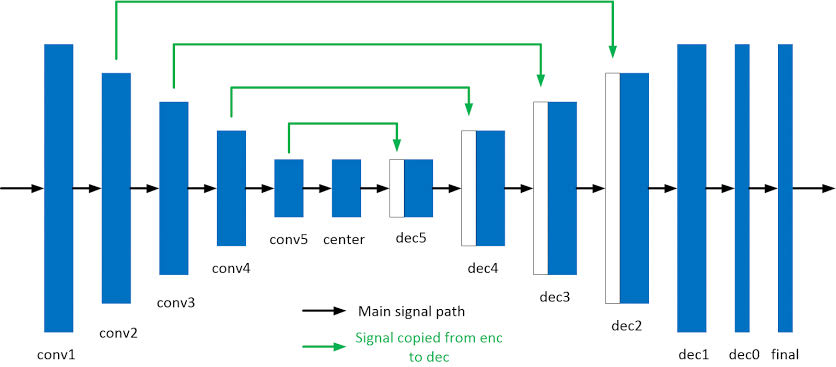
<center>
    <figcaption>Figure 6. Skip connections from encoder to U-Net like decoder. [4]</figcaption>
</center>
</figure>

To achieve that we turned to the feature pyramid network (FPN) decoder, which is what used in the U-Net [3] as well. So, we added the FPN decoder to the PSPNet encoder, which can is capable of capturing the small features from the image.

### Implementation in `arcgis.learn`

By default we create a FPN like decoder while initializing the `PSPNetClassifier` object. We can do that by

`psp = PSPNetClassifier(data=data)`. Here data is fastai databunch, object returned by `prepare_data` function.

To create a pspnet classifier with 8x upsampling decoder.

`psp = PSPNetClassifier(data=data, use_unet=False)`

Then we can continue with the basic `arcgis.learn` workflow.

### PointRend Enhancement

Segmentation models can tend to generate over-smooth boundaries which might not be precise for objects or scenes with irregular boundaries. To get a crisp segmentation boundary, a point-based rendering neural network module called [**PointRend**](https://arxiv.org/abs/1912.08193) has been added as an enhancement to the existing model. This module draws methodology from classical computer graphics and gives the perspective of rendering to a segmentation problem. Image segmentation models often predict labels on a low-resolution regular grid, for example, 1/8th of the input. These models use interpolation to upscale the predictions to original resolution. In contrast, PointRend uses iterative subdivision algorithm to upscale the predictions by predicting labels of points at selected locations by a trained small neural network. This method enables high-resolution output in an efficient way. [9]

<center><img src="../../static/img/pointrend_pspnet.jpg"/></center>
<center>Figure 7. PointRend enhancements (right, marked with red arrows) over original segmentation model (left) [9]</center>

To enable PointRend with PSPNet, initialize the model with parameter `pointrend=True`:
```
psp = PSPNetClassifier(data=data, pointrend=True)
```

### Summary

In this guide we learnt the various details of PSPNet model and how we can initialize the model of our choice in `arcgis.learn`.

### References

[1] H. Zhao, J. Shi, X. Qi, X. Wang, and J. Jia.  Pyramid sceneparsing network.arXiv:1612.01105, 2016

[2] Sik-Ho Tsang. Review: DilatedNet — Dilated Convolution (Semantic Segmentation). https://towardsdatascience.com/review-dilated-convolution-semantic-segmentation-9d5a5bd768f5. Accessed 10 November 2019.

[3] Olaf Ronneberger, Philipp Fischer: “U-Net: Convolutional Networks for Biomedical Image Segmentation”, 2015; [http://arxiv.org/abs/1505.04597 arXiv:1505.04597].

[4] Nan Zhang's. A PyTorch implementation of Image Segmentation Using UNet, Stratification and K-Fold Learning. http://goldsequence.blogspot.com/2018/11/a-pytorch-implementation-of-image.html. Accessed 11 November 2019

[5] Hengshuang Zhao. PSPNet. https://github.com/hszhao/PSPNet. Accessed 11 November 2019

[6] Machine Intelligence for humans. Image segmentation with Deep learning. https://www.hackevolve.com/image-segmentation-using-deep-learning/. Accessed 12 November 2019

[7] kazucmpt. Questions about PSPNet. https://github.com/hszhao/PSPNet/issues/101. Accessed 12 November 2019

[8] Fisher Yu, Vladlen Koltun: “Dilated Residual Networks”, 2017

[9] Alexander Kirillov, Yuxin Wu, Kaiming He, Ross Girshick: “PointRend: Image Segmentation as Rendering”, 2019; [http://arxiv.org/abs/1912.08193 arXiv:1912.08193].